In [1]:
%matplotlib inline
 
import numpy as np
import matplotlib.pyplot as plt

# Load dataset


In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)

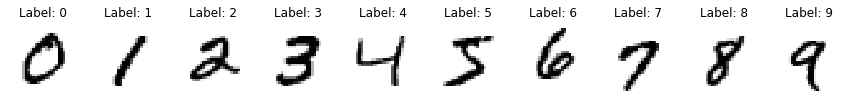

In [3]:
# use np.unique to get all unique values in the list of labels
labels, indexes = np.unique(y, return_index=True)
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)

for ax, label, idx in zip(axes, labels, indexes):
    digit = X[idx]
    digit_image = digit.reshape(28, 28)     
    ax.imshow(digit_image, cmap='binary')
    ax.axis('off')
    ax.set_title("Label: " + str(label))

In [4]:
N = 60000
X_train, X_test, y_train, y_test = X[:N], X[N:], y[:N], y[N:]

In [5]:
def print_cv_accuracy(scores):
  # The mean score and the 95% confidence interval of the score estimate
  accuracy_scores = 100 * scores  
  print("Accuracy: {:.1f} % (+/- {:.1f})".format(accuracy_scores.mean(), accuracy_scores.std() * 2))

# Pixels as features

## SGD Classifier (linear)

We create a SGD Classifier

In [69]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

# Cross validation on default SGD classifier
sgd_clf = SGDClassifier(random_state=42, max_iter=1000) # loss: 'hinge', penalty: 'l2'
scores = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy") 

print("Scores: ", scores) # [0.87082583 0.87089354 0.88628294]
print_cv_accuracy(scores) # 87.6 (+/- 1.5)

[0.87082583 0.87089354 0.88628294]
Accuracy: 87.60 (+/- 1.45)


https://scikit-learn.org/stable/modules/sgd.html

Stochastic Gradient Descent is sensitive to feature scaling, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1. Note that the same scaling must be applied to the test vector to obtain meaningful results. This can be easily done using StandardScaler:

In [0]:
from sklearn.preprocessing import StandardScaler

# 1. Stochastic Gradient Descent is sensitive to feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [71]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000)
scores = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

print("Scores: ", scores) # [0.89957009 0.89344467 0.89963495]
print_cv_accuracy(scores) # Accuracy: 89.8 (+/- 0.6)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[0.89957009 0.89344467 0.89963495]
Accuracy: 89.75 (+/- 0.58)


- Finding a reasonable regularization term is best done using GridSearchCV, usually in the range 10.0**-np.arange(1,7).
- l1’ and ‘elasticnet’ might bring sparsity to the model (feature selection) not achievable with ‘l2’.
- The ‘log’ loss gives logistic regression, a probabilistic classifier. ‘modified_huber’ is another smooth loss that brings tolerance to outliers as well as probability estimates. ‘squared_hinge’ is like hinge but is quadratically penalized. ‘perceptron’ is the linear loss used by the perceptron algorithm.

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : 10.0**-np.arange(1,7),
    "penalty" : ["l2", "l1", "none"],
}

grid_search = GridSearchCV(sgd_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_train_scaled, y_train)

## Random Forest (non-linear)


### Model selection

In [77]:
from sklearn.ensemble import RandomForestClassifier

# Cross validation on default Random Forest classifier
forest_clf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

print("Scores: ", scores) # [0.96545691 0.9619981  0.96684503]
print_cv_accuracy(scores) # Accuracy: 96.5 (+/- 0.4)

Scores:  [0.96545691 0.9619981  0.96684503]
Accuracy: 96.5 (+/- 0.4)


In [79]:
# Cross validation on default Random Forest classifier with Scaled input
forest_clf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

print("Scores: ", scores) # [0.96545691 0.9619981  0.96684503]
print_cv_accuracy(scores) # Accuracy: 96.5 (+/- 0.4)
# Pas d'amélioration cette fois ci => explain why
# Scaling is done to Normalize data so that priority is not given to a particular feature. Role of Scaling is mostly important in algorithms that are distance based and require Euclidean Distance.
# Random Forest is a tree-based model and hence does not require feature scaling.

Scores:  [0.96465707 0.9619481  0.96629494]
Accuracy: 96.4 (+/- 0.4)


### Fine-tuning

In [81]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators" : [10, 50, 100, 150, 200, 250],
    "max_features": ["sqrt", "log2", None]
}

grid_search = GridSearchCV(forest_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='w

In [87]:
print(grid_search.best_score_) # 0.96635
print(grid_search.best_params_) # {'max_features': 'sqrt', 'n_estimators': 250}


0.96635
{'max_features': 'sqrt', 'n_estimators': 250}


In [84]:
cv_res = grid_search.cv_results_
for mean_score, params in zip(cv_res["mean_test_score"], cv_res["params"]):
    print(mean_score, params)

0.9398333333333333 {'max_features': 'sqrt', 'n_estimators': 10}
0.96235 {'max_features': 'sqrt', 'n_estimators': 50}
0.9650333333333333 {'max_features': 'sqrt', 'n_estimators': 100}
0.96555 {'max_features': 'sqrt', 'n_estimators': 150}
0.96585 {'max_features': 'sqrt', 'n_estimators': 200}
0.96635 {'max_features': 'sqrt', 'n_estimators': 250}
0.9266666666666666 {'max_features': 'log2', 'n_estimators': 10}
0.9582 {'max_features': 'log2', 'n_estimators': 50}
0.9617166666666667 {'max_features': 'log2', 'n_estimators': 100}
0.9629166666666666 {'max_features': 'log2', 'n_estimators': 150}
0.9646166666666667 {'max_features': 'log2', 'n_estimators': 200}
0.964 {'max_features': 'log2', 'n_estimators': 250}
0.9322166666666667 {'max_features': None, 'n_estimators': 10}
0.9469666666666666 {'max_features': None, 'n_estimators': 50}
0.94865 {'max_features': None, 'n_estimators': 100}
0.9481166666666667 {'max_features': None, 'n_estimators': 150}
0.9495833333333333 {'max_features': None, 'n_estimator

In [0]:
#TODO: test forest_clf.feature_importances_


### Training and evaluation

In [6]:
# Train best model
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=250, max_features='sqrt')
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [19]:
from sklearn.metrics import accuracy_score

# Evaluate on test set
y_pred = forest_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.1f}".format(100*accuracy)) # Accuracy: 97.2

Accuracy: 97.2


In [ ]:
# Dump / Load model

In [16]:
import joblib
import os

MODELS_PATH = '../models/mnist'
FOREST_MODEL_PATH = os.path.join(MODELS_PATH, 'forest_clf.joblib')

In [17]:
# Dump
joblib.dump(forest_clf, FOREST_MODEL_PATH)

['../models/mnist/forest_clf.joblib']

In [18]:
# Load 
forest_clf = joblib.load(FOREST_MODEL_PATH)

In [0]:
# TODO: analyse filures:
# confusion matrix
#  display failures

## Random Forest

### Model selection

### Training and evaluation

# Feature extraction

## HOG features



### Testing HOG Features

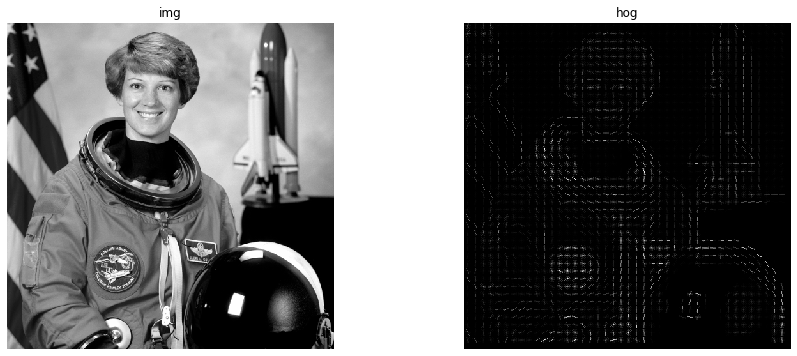

In [32]:
from skimage.feature import hog
from skimage import data
from skimage.transform import rescale
from skimage.color import rgb2gray

original = data.astronaut()
img = rgb2gray(original)

# calculate the hog and return a visual representation.
img_hog, img_hog_viz = hog(
    img, pixels_per_cell=(12, 12),
    cells_per_block=(2,2),
    orientations=8,
    visualize=True,
    block_norm='L2-Hys')

# Plot
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,6)

ax[0].imshow(img, cmap='gray')
ax[0].set_title('img')
ax[0].axis("off")
ax[1].imshow(img_hog_viz, cmap='gray')
ax[1].set_title('hog')
ax[1].axis("off")

plt.show()

In [41]:
number_of_pixels = img.shape[0] * img.shape[1]
number_of_hog_features = img_hog.shape[0]
diff = number_of_hog_features / number_of_pixels * 100

print('Number of pixels: ', number_of_pixels)
print('Number of hog features: ', number_of_hog_features)
print('Diff: {:.1f} %'.format(diff)) # ~ 20% less features !

Number of pixels:  262144
Number of hog features:  53792
Diff: 20.5 %


### Scikit-Learn Transformers


https://kapernikov.com/tutorial-image-classification-with-scikit-learn/


In [0]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
 
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [47]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
import skimage

X_train_reshape = [digit.reshape(28, 28) for digit in X_train]
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(8, 8),
    cells_per_block=(2,2),
    orientations=9,
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
#X_train_gray = grayify.fit_transform(X_train_reshape)
X_train_hog = hogify.fit_transform(X_train_reshape)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(60000, 144)


In [50]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
cross_val_score(sgd_clf, X_train_prepared, y_train, cv=3, scoring="accuracy")

array([0.91231754, 0.9100955 , 0.91093664])

# Conv Nets